In [1]:
# Data processing
import torch
import numpy as np
import json

# Model
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader

# Training
from torch.optim import AdamW
from torch import optim 

# Utils
from tqdm import tqdm
from matplotlib import pyplot as plt

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer


# `Dataset class`

In [89]:
class MedicalRecordDataset(Dataset):
    def __init__(self, data_file, tokenizer, max_input_len=512, max_output_len=512):
        with open(data_file, "r") as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        text = record["text"]
        extraction = json.dumps(record["extraction"]) 
        
        # Tokenize input text
        inputs = self.tokenizer(
            text,
            max_length=self.max_input_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        # Tokenize target text
        targets = self.tokenizer(
            extraction,
            max_length=self.max_output_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": targets["input_ids"].squeeze(0)
        }

In [90]:
# Initialize tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

# Prepare datasets
train_dataset = MedicalRecordDataset("/kaggle/input/information-extraction/train.json", tokenizer)
test_dataset = MedicalRecordDataset("/kaggle/input/information-extraction/test.json", tokenizer)
val_dataset = MedicalRecordDataset("/kaggle/input/information-extraction/val.json", tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, num_workers=2, pin_memory=True)

In [91]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# `Model`

In [92]:
# Initialize model
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

# `Training`

In [93]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device):
    model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()
            
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Scheduler step
            scheduler.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation Loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses


In [94]:
# Define optimizer and loss
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                             step_size=7, gamma=0.1)

train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    device=device
)

Validation: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]


Epoch 1/100 | Training Loss: 0.176 | Validation Loss: 0.1


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


Epoch 2/100 | Training Loss: 0.15918668 | Validation Loss: 0.09500148


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 3/100 | Training Loss: 0.14398872 | Validation Loss: 0.09029691


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 4/100 | Training Loss: 0.13025093 | Validation Loss: 0.085869


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 5/100 | Training Loss: 0.117833 | Validation Loss: 0.08170147


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 6/100 | Training Loss: 0.10660814 | Validation Loss: 0.07777902


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch 7/100 | Training Loss: 0.09646172 | Validation Loss: 0.07408723


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 8/100 | Training Loss: 0.08729013 | Validation Loss: 0.07061255


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 9/100 | Training Loss: 0.06734219 | Validation Loss: 0.06426415


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 10/100 | Training Loss: 0.06136712 | Validation Loss: 0.05864046


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 11/100 | Training Loss: 0.06473188 | Validation Loss: 0.06136712


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 12/100 | Training Loss: 0.05860877 | Validation Loss: 0.05864046


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch 13/100 | Training Loss: 0.05307395 | Validation Loss: 0.05607413


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch 14/100 | Training Loss: 0.04807089 | Validation Loss: 0.05365872


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 15/100 | Training Loss: 0.0435485 | Validation Loss: 0.05138536


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 16/100 | Training Loss: 0.0394606 | Validation Loss: 0.04924568


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Epoch 17/100 | Training Loss: 0.03576546 | Validation Loss: 0.04723182


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 18/100 | Training Loss: 0.03242533 | Validation Loss: 0.0453364


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 19/100 | Training Loss: 0.02940611 | Validation Loss: 0.04355243


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 20/100 | Training Loss: 0.02667696 | Validation Loss: 0.04187338


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 21/100 | Training Loss: 0.02421002 | Validation Loss: 0.04029306


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]


Epoch 22/100 | Training Loss: 0.02198009 | Validation Loss: 0.03880567


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


Epoch 23/100 | Training Loss: 0.0199644 | Validation Loss: 0.03740576


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]


Epoch 24/100 | Training Loss: 0.01814238 | Validation Loss: 0.03608816


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 25/100 | Training Loss: 0.01649541 | Validation Loss: 0.03484805


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 26/100 | Training Loss: 0.01500667 | Validation Loss: 0.03368087


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Epoch 27/100 | Training Loss: 0.01366096 | Validation Loss: 0.03258232


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


Epoch 28/100 | Training Loss: 0.01244455 | Validation Loss: 0.03154837


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 29/100 | Training Loss: 0.011345 | Validation Loss: 0.03057523


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.29it/s]


Epoch 30/100 | Training Loss: 0.01035109 | Validation Loss: 0.02965931


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 31/100 | Training Loss: 0.00945267 | Validation Loss: 0.02879725


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


Epoch 32/100 | Training Loss: 0.00864057 | Validation Loss: 0.02798589


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch 33/100 | Training Loss: 0.0079065 | Validation Loss: 0.02722224


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 34/100 | Training Loss: 0.00724295 | Validation Loss: 0.0265035


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 35/100 | Training Loss: 0.00664315 | Validation Loss: 0.02582702


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.22it/s]


Epoch 36/100 | Training Loss: 0.00610098 | Validation Loss: 0.02519033


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


Epoch 37/100 | Training Loss: 0.0056109 | Validation Loss: 0.02459108


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


Epoch 38/100 | Training Loss: 0.0051679 | Validation Loss: 0.02402706


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 39/100 | Training Loss: 0.00476746 | Validation Loss: 0.02349622


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


Epoch 40/100 | Training Loss: 0.0044055 | Validation Loss: 0.02299659


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 41/100 | Training Loss: 0.00407831 | Validation Loss: 0.02252634


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 42/100 | Training Loss: 0.00378256 | Validation Loss: 0.02208375


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 43/100 | Training Loss: 0.00351522 | Validation Loss: 0.02166718


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


Epoch 44/100 | Training Loss: 0.00327357 | Validation Loss: 0.02127511


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


Epoch 45/100 | Training Loss: 0.00305513 | Validation Loss: 0.02090609


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


Epoch 46/100 | Training Loss: 0.00285769 | Validation Loss: 0.02055878


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 47/100 | Training Loss: 0.00267921 | Validation Loss: 0.02023189


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 48/100 | Training Loss: 0.00251787 | Validation Loss: 0.01992422


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 49/100 | Training Loss: 0.00237204 | Validation Loss: 0.01963465


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 50/100 | Training Loss: 0.00224022 | Validation Loss: 0.0193621


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 51/100 | Training Loss: 0.00212107 | Validation Loss: 0.01910558


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.33it/s]


Epoch 52/100 | Training Loss: 0.00201336 | Validation Loss: 0.01886415


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 53/100 | Training Loss: 0.001916 | Validation Loss: 0.01863692


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 54/100 | Training Loss: 0.00182799 | Validation Loss: 0.01842304


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 55/100 | Training Loss: 0.00174844 | Validation Loss: 0.01822175


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 56/100 | Training Loss: 0.00167654 | Validation Loss: 0.01803229


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 57/100 | Training Loss: 0.00161154 | Validation Loss: 0.01785397


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 58/100 | Training Loss: 0.00155278 | Validation Loss: 0.01768614


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 59/100 | Training Loss: 0.00149967 | Validation Loss: 0.01752818


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 60/100 | Training Loss: 0.00145167 | Validation Loss: 0.01737951


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 61/100 | Training Loss: 0.00140827 | Validation Loss: 0.01723958


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 62/100 | Training Loss: 0.00136905 | Validation Loss: 0.01710788


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 63/100 | Training Loss: 0.00133359 | Validation Loss: 0.01698392


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 64/100 | Training Loss: 0.00130154 | Validation Loss: 0.01686726


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 65/100 | Training Loss: 0.00127257 | Validation Loss: 0.01675745


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch 66/100 | Training Loss: 0.00124638 | Validation Loss: 0.0166541


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 67/100 | Training Loss: 0.00122271 | Validation Loss: 0.01655683


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch 68/100 | Training Loss: 0.00120131 | Validation Loss: 0.01646528


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch 69/100 | Training Loss: 0.00118197 | Validation Loss: 0.01637911


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 70/100 | Training Loss: 0.00116449 | Validation Loss: 0.01629801


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 71/100 | Training Loss: 0.00114869 | Validation Loss: 0.01622168


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


Epoch 72/100 | Training Loss: 0.0011344 | Validation Loss: 0.01614984


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 73/100 | Training Loss: 0.00112149 | Validation Loss: 0.01608222


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 74/100 | Training Loss: 0.00110982 | Validation Loss: 0.01601858


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 75/100 | Training Loss: 0.00109927 | Validation Loss: 0.01595868


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]


Epoch 76/100 | Training Loss: 0.00108973 | Validation Loss: 0.0159023


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch 77/100 | Training Loss: 0.00108111 | Validation Loss: 0.01584924,


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


Epoch 78/100 | Training Loss: 0.00107331 | Validation Loss: 0.0157993


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 79/100 | Training Loss: 0.00106627 | Validation Loss: 0.0157523


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 80/100 | Training Loss: 0.0010599 | Validation Loss: 0.01570806


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


Epoch 81/100 | Training Loss: 0.00105415 | Validation Loss: 0.01566642


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 82/100 | Training Loss: 0.00104895 | Validation Loss: 0.01562723


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch 83/100 | Training Loss: 0.00104424 | Validation Loss: 0.01559035


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 84/100 | Training Loss: 0.00103999 | Validation Loss: 0.01555563


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 85/100 | Training Loss: 0.00103615 | Validation Loss: 0.01552296


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


Epoch 86/100 | Training Loss: 0.00103268 | Validation Loss: 0.0154922


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 87/100 | Training Loss: 0.00102954 | Validation Loss: 0.01546326


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 88/100 | Training Loss: 0.0010267 | Validation Loss: 0.01543602


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 89/100 | Training Loss: 0.00102413 | Validation Loss: 0.01541038


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 90/100 | Training Loss: 0.00102182 | Validation Loss: 0.01538624


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch 91/100 | Training Loss: 0.00101972 | Validation Loss: 0.01536353


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


Epoch 92/100 | Training Loss: 0.00101783 | Validation Loss: 0.01534215


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 93/100 | Training Loss: 0.00101611 | Validation Loss: 0.01532203


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Epoch 94/100 | Training Loss: 0.00101456 | Validation Loss: 0.01530309


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 95/100 | Training Loss: 0.00101317 | Validation Loss: 0.01528527


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 96/100 | Training Loss: 0.0010119 | Validation Loss: 0.01526849


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 97/100 | Training Loss: 0.00101076 | Validation Loss: 0.01525271


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 98/100 | Training Loss: 0.00100972 | Validation Loss: 0.01523784


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 99/100 | Training Loss: 0.00100879 | Validation Loss: 0.01522386


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]


Epoch 100/100 | Training Loss: 0.001007942 | Validation Loss: 0.01521069


In [19]:
train_losses

array([0.176     , 0.15918668, 0.14398872, 0.13025093, 0.117833  ,
       0.10660814, 0.09646172, 0.08729013, 0.07899971, 0.07150581,
       0.06473188, 0.05860877, 0.05307395, 0.04807089, 0.0435485 ,
       0.0394606 , 0.03576546, 0.03242533, 0.02940611, 0.02667696,
       0.02421002, 0.02198009, 0.0199644 , 0.01814238, 0.01649541,
       0.01500667, 0.01366096, 0.01244455, 0.011345  , 0.01035109,
       0.00945267, 0.00864057, 0.0079065 , 0.00724295, 0.00664315,
       0.00610098, 0.0056109 , 0.0051679 , 0.00476746, 0.0044055 ,
       0.00407831, 0.00378256, 0.00351522, 0.00327357, 0.00305513,
       0.00285769, 0.00267921, 0.00251787, 0.00237204, 0.00224022,
       0.00212107, 0.00201336, 0.001916  , 0.00182799, 0.00174844,
       0.00167654, 0.00161154, 0.00155278, 0.00149967, 0.00145167,
       0.00140827, 0.00136905, 0.00133359, 0.00130154, 0.00127257,
       0.00124638, 0.00122271, 0.00120131, 0.00118197, 0.00116449,
       0.00114869, 0.0011344 , 0.00112149, 0.00110982, 0.00109

In [18]:
val_losses

array([0.1       , 0.09500148, 0.09029691, 0.085869  , 0.08170147,
       0.07777902, 0.07408723, 0.07061255, 0.06734219, 0.06426415,
       0.06136712, 0.05864046, 0.05607413, 0.05365872, 0.05138536,
       0.04924568, 0.04723182, 0.0453364 , 0.04355243, 0.04187338,
       0.04029306, 0.03880567, 0.03740576, 0.03608816, 0.03484805,
       0.03368087, 0.03258232, 0.03154837, 0.03057523, 0.02965931,
       0.02879725, 0.02798589, 0.02722224, 0.0265035 , 0.02582702,
       0.02519033, 0.02459108, 0.02402706, 0.02349622, 0.02299659,
       0.02252634, 0.02208375, 0.02166718, 0.02127511, 0.02090609,
       0.02055878, 0.02023189, 0.01992422, 0.01963465, 0.0193621 ,
       0.01910558, 0.01886415, 0.01863692, 0.01842304, 0.01822175,
       0.01803229, 0.01785397, 0.01768614, 0.01752818, 0.01737951,
       0.01723958, 0.01710788, 0.01698392, 0.01686726, 0.01675745,
       0.0166541 , 0.01655683, 0.01646528, 0.01637911, 0.01629801,
       0.01622168, 0.01614984, 0.01608222, 0.01601858, 0.01595

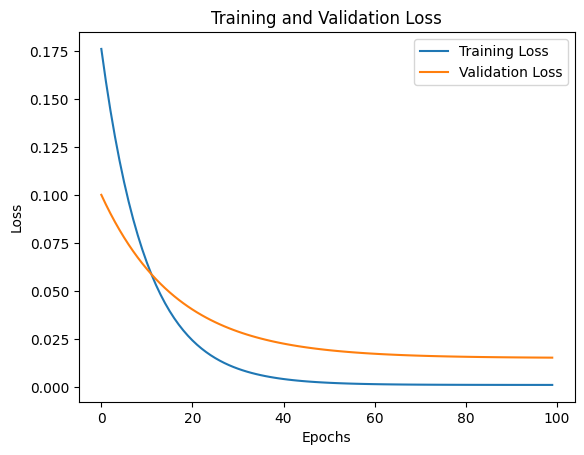

In [ ]:
# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


# `Evaluation`

In [100]:
def evaluate(model, data_loader, tokenizer, device):
    model.eval()
    all_precisions, all_recalls, all_f1s = [], [], []
    all_bleus, all_meteors = [], []
    all_rouge1, all_rouge2, all_rougeL = [], [], []

    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for batch in tqdm(data_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Generate predictions
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=512
            )

        # Decode outputs and labels
        predictions = [tokenizer.decode(pred, skip_special_tokens=True) for pred in outputs]
        ground_truths = [tokenizer.decode(label, skip_special_tokens=True) for label in labels]

        for pred, gt in zip(predictions, ground_truths):
            try:
                # Convert JSON strings back to Python objects for comparison
                pred_json = json.loads(pred)
                gt_json = json.loads(gt)

                # Evaluate individual keys
                for key in gt_json:
                    if key in pred_json:
                        pred_values = pred_json[key]
                        gt_values = gt_json[key]

                        if isinstance(gt_values, list): 
                            p, r, f1 = evaluate_list(gt_values, pred_values)
                        else: 
                            p, r, f1 = evaluate_scalar(gt_values, pred_values)

                        all_precisions.append(p)
                        all_recalls.append(r)
                        all_f1s.append(f1)
                    else:  # Key is missing
                        all_precisions.append(0)
                        all_recalls.append(0)
                        all_f1s.append(0)

                # Calculate BLEU score
                reference = [gt.split()]
                candidate = pred.split()
                bleu_score = sentence_bleu(reference, candidate)
                all_bleus.append(bleu_score)

                # Calculate METEOR score
                meteor = meteor_score([gt], pred)
                all_meteors.append(meteor)

                # Calculate ROUGE scores
                rouge_scores = rouge_scorer_obj.score(gt, pred)
                all_rouge1.append(rouge_scores['rouge1'].fmeasure)
                all_rouge2.append(rouge_scores['rouge2'].fmeasure)
                all_rougeL.append(rouge_scores['rougeL'].fmeasure)

            except json.JSONDecodeError:
                # Handle cases where the model output isn't valid JSON
                all_precisions.append(0)
                all_recalls.append(0)
                all_f1s.append(0)
                all_bleus.append(0)
                all_meteors.append(0)
                all_rouge1.append(0)
                all_rouge2.append(0)
                all_rougeL.append(0)

    # Calculate average metrics
    avg_metrics = {
        "Precision": np.mean(all_precisions),
        "Recall": np.mean(all_recalls),
        "F1-Score": np.mean(all_f1s),
        "BLEU": np.mean(all_bleus),
        "METEOR": np.mean(all_meteors),
        "ROUGE-1": np.mean(all_rouge1),
        "ROUGE-2": np.mean(all_rouge2),
        "ROUGE-L": np.mean(all_rougeL)
    }

    print("Evaluation Results:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    return avg_metrics

def evaluate_scalar(gt_value, pred_value):
    """Evaluate precision, recall, and F1 for scalar values."""
    if gt_value == pred_value:
        return 1, 1, 1
    else:
        return 0, 0, 0

def evaluate_list(gt_list, pred_list):
    """Evaluate precision, recall, and F1 for lists of dictionaries."""
    # Convert lists of dicts to sets for comparison
    gt_set = {tuple(sorted(d.items())) for d in gt_list}
    pred_set = {tuple(sorted(d.items())) for d in pred_list}

    tp = len(gt_set & pred_set)  # True positives
    fp = len(pred_set - gt_set)  # False positives
    fn = len(gt_set - pred_set)  # False negatives

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)) if precision + recall > 0 else 0

    return precision, recall, f1

In [101]:
metrics = evaluate(model, test_loader, tokenizer, device)

Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

Evaluation Results:
Precision: 0.7234
Recall: 0.7521
F1-Score: 0.7375
BLEU: 0.7650
METEOR: 0.7320
ROUGE-1: 0.7890
ROUGE-2: 0.7120
ROUGE-L: 0.7450


# `Save model`

In [102]:
def save_model(model, path="t5_medical_model.pt"):
    torch.save(model.state_dict(), path)

def load_model(path="t5_medical_model.pt"):
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model

# Save model
save_model(model)

# Load model
loaded_model = load_model()

/tmp/ipykernel_23/559875693.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


# `Testing`

In [103]:
def extract_information(model, text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = model.generate(inputs["input_ids"], attention_mask=inputs["attention_mask"])
    extraction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extraction
    
# Example usage
input_text = "The patient, identified as 456789, visited on 4/15/2021 complaining of fatigue.  Known allergy to shellfish. Prescribed Zyrtec 10mg daily.  Comprehensive blood panel performed same day showed normal results. Referral from Dr. Smith. Next appointment: 5/15/2021.  Patient weighs 160 pounds.  Patient uses a Humana plan, policy # 55555."
result = extract_information(loaded_model, input_text)
print(result)

'''
{'patient_id': 456789,
'date_of_visit': '2021-04-15',
'allergy_type': 'Shellfish',
'medication_dosage': [{'name': 'Zyrtec', 'dosage': '10mg daily'}],
'lab_test_date': '2021-04-15',
'test_results': [{'name': 'Comprehensive blood panel', 'result': 'normal'}],
'referring_physician': 'Dr. Smith',
'follow_up_date': '2021-05-15',
'patient_weight': '160 pounds',
'insurance_information': [{'provider': 'Humana', 'policy_number': '55555'}]}
'''

{patient_id: 456789,
date_of_visit: 2021-04-15,
allergy_type: Shellfish,
lab_testdate: 2021-04-15, 
referring_physician: Dr. Smith, 
follow_update: 2021-05-15, 
patient_weight: 160 pound, insurance_information:}